In [1]:
%%bash
# No installer for this, so we grab it from the repo
wget -q https://raw.githubusercontent.com/GNOME-physics/3_23_2016_data_analysis/master/gnome_da.py
ls gnome_da.py

gnome_da.py


In [1]:
import os
import math
import glob
from pprint import pprint

import numpy
import matplotlib
%matplotlib inline
from matplotlib import pyplot
import h5py

from glue.segments import segment, segmentlist, segmentlistdict

import gwpy
print gwpy.__version__
from gwpy.timeseries import TimeSeries, TimeSeriesList
from gwpy.segments import SegmentList
try:
    from gwpy.plotter import FrequencySeriesPlot
except ImportError:
    from gwpy.plotter import SpectrumPlot
from gwpy.plotter import TimeSeriesPlot, SpectrogramPlot, SegmentPlot
from gwpy.segments import DataQualityDict, DataQualityFlag

from astropy.units import Quantity

import gnome_da

0.1b4.dev171


## Station Color Mappings

These are color mappings I've arbitrarily chosen for each station. They can be adjusted if necessary.

In [14]:
station_map = {
    "berkeley": 'r',
    "mainz": 'b',
    "fribourg": 'g',
    "hayward": 'c',
    "krakow": 'k'
}

'\nstation_map = {\n    "berkeley": \'r\',\n    "mainz": \'b\',\n}\n'

## Retrieve and store data

We will need to get, unpack, and store the data. The `basepath` variable below stores the directory stem.

**TODO**: Get data tutorial (can we do it through bash?)

In [15]:
# Path stem for all data in hierarchal, timestamped folder system
base_path = "/Users/chrispankow/work/comag/3_23_2016_data"
# Name of the HDF5 data set holding magnetometer data
setname = "MagneticFields"

## Utility Functions

TODO: Send them to `gnome_da`.

In [16]:
def retrieve_file_paths(base_path, station, gps_start=None, gps_end=None):
    """
    Get all the paths for a given station in a base_path.
    TODO: convert gps segment to UTC and format the path appropriately.
    """
    path_glob = os.path.join(base_path, \
                             "data/GNOMEDrive/gnome/serverdata/%s01/2016/03/23/%s01_20160323_*.hdf5" \
                             % (station, station))
    return glob.glob(path_glob)

def generate_timeseries(data_list, setname="MagneticFields"):

    full_data = TimeSeriesList()
    for seg in sorted(data_list):
        hfile = h5py.File(data_list[seg], "r")
        full_data.append(gnome_da.retrieve_data_timeseries(hfile, "MagneticFields"))
        hfile.close()

    return full_data

## Data file metadata

Each file corresponds to about 60 seconds of data, but the glob does not preserve chronological order. We glob the files, order them and record some metadata

In [17]:
print "Globbing and loading file metadata"
data_order = {}
for station, color in station_map.iteritems():
    data_order[station] = {}

    #
    # Figure out the order of the data files to fill in the time series
    #
    for fname in gnome_da.retrieve_file_paths(base_path, station):
        hfile = h5py.File(fname, "r")
        data_order[station][gnome_da._file_to_segment(hfile)] = fname
        hfile.close()

print "...done, %d stations loaded" % len(data_order)
print "Stations loaded: %s" % ", ".join(data_order)

# Uncomment to view a mapping of the data segments to the filenames
#pprint(data_order)

Globbing and loading file metadata
...done, 5 stations loaded
Stations loaded: mainz, krakow, fribourg, berkeley, hayward


## Establishing active times

The data itself is segmented, and sometimes files will be missing. We first establish "segments" of time where we have data.

Generating segment lists for each station
Done. Segment list summary:
-- mainz ---------
1142726468.000000 1142730128.000000
-- hayward ---------
1142726456.000000 1142730116.000000
-- fribourg ---------
1142726422.000000 1142730082.000000
-- krakow ---------
1142726427.000000 1142730087.000000
-- berkeley ---------
1142726425.000000 1142726665.000000
1142726667.000000 1142726847.000000
1142728250.000000 1142728310.000000
1142728312.000000 1142728432.000000
1142728434.000000 1142728494.000000
1142728496.000000 1142728856.000000
1142728858.000000 1142729038.000000
1142729040.000000 1142729640.000000
1142729642.000000 1142729702.000000
1142729704.000000 1142730124.000000


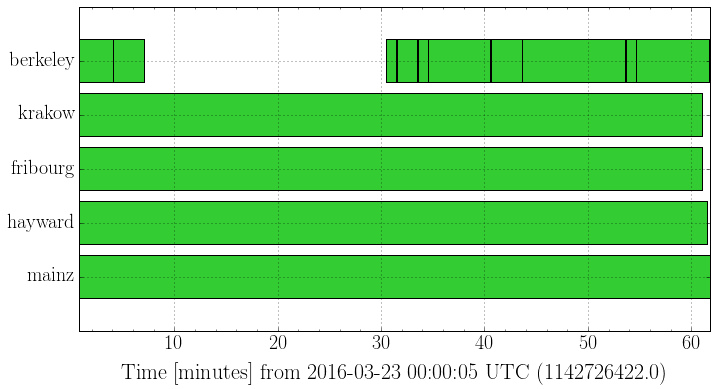

In [18]:
full_seglist = DataQualityDict()

print "Generating segment lists for each station"
for station, color in station_map.iteritems():
    #
    # Generate an ASCII representation of the GPS timestamped segments of time
    # covered by the input data
    #
    seglist = segmentlist(data_order[station].keys())
    seglist.sort()
    span = seglist.extent()
    with open("%s_segments_%d_%d.txt" % (station, span[0], span[1]), "w") as fout:
        for seg in seglist:
            print >>fout, "%10.9f %10.9f" % seg

    # FIXME: Active should be masked from the sanity channel
    full_seglist[station] = DataQualityFlag(station, active=seglist.coalesce(), known=seglist.coalesce())

from gwpy.plotter import SegmentPlot
plot = SegmentPlot()
ax = plot.gca()
ax.plot(full_seglist);

print "Done. Segment list summary:"
for station, segl in full_seglist.iteritems():
    print "-- %s ---------" % station
    for seg in segl.active:
        print "%10.6f %10.6f" % seg

## Retrieve and concatenate the data

We now want to get all the data in the period of interest so we can analyze it in different ways. This can be tricky for non-contiguous data, but luckily `gwpy` has many ways of dealing with this.

In [20]:
full_data = {}
for station in station_map:
    full_data[station] = generate_timeseries(data_order[station], setname)

# We don't really need this any more, so it can be deleted
del data_order

-- mainz -------
1142726468.0 1142730128.0
-- krakow -------
1142726427.0 1142730087.0
-- fribourg -------
1142726422.0 1142730082.0
-- berkeley -------
1142726425.0 1142730124.0
-- hayward -------
1142726456.0 1142730116.0


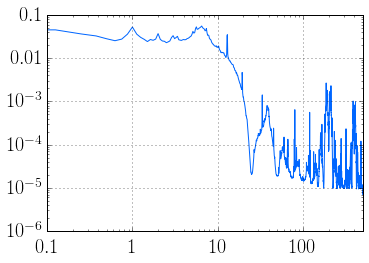

In [25]:
# To superimpose all time series plots ontop of each other
#all_plot = TimeSeriesPlot()

tsplot = {}
for station, data_list in full_data.iteritems():
    print "-- %s -------" % station
    station_seglist = full_seglist[station]
    start, end = station_seglist.active.extent()
    print start, end

    #
    # Generate a plot of the data time series
    #
    tsplot[station] = TimeSeriesPlot()
    ax = tsplot[station].gca()
    for ts in data_list:
        ax.plot(ts, color=station_map[station])
    ax.set_title(station)
    tsplot[station].add_state_segments(SegmentList(station_seglist.active), \
                            plotargs={'label': 'data present', 'facecolor': 'g', 'edgecolor': 'k'})
    ax.set_xlim(start, end)
    tsplot[station].savefig("%s_time_series_%d_%d.png" % (station, start, end))

    # AGG complexity starts to complain with large numbers of points
    # And we somehow invoke precision issues that need to be ameliorated
    for d in data_list:
        d.x0 = Quantity(int(d.x0.value * 1000), d.xunit)
        d.dx = Quantity(1, d.xunit)
    data_list.coalesce()
    for d in data_list:
        d.x0 = Quantity(d.x0.value / 1000, d.xunit)
        d.dx = Quantity(0.001, d.xunit)

    #
    # Generate an amplitude spectrum density plot
    #
    plot = SpectrumPlot()
    for d in data_list:
        spectrum = d.asd(8, 4) # 8 seconds per FFT, 4 second (50% overlap)
        ax = plot.gca()
        ax.plot(spectrum)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-1, 500)
    plot.savefig("%s_spectrum_%d_%d.png" % (station, start, end))

    #
    # Generate a spectorgram plot, and a normalized spectrogram plot
    # norm: \sqrt{S(f,t)} / \sqrt{\overbar{S(f)}}
    #
    plot = SpectrogramPlot()
    white_plot = SpectrogramPlot()
    ax = plot.gca()
    wax = white_plot.gca()
    for ts in data_list:
        print ts.x0
        if (len(ts) * ts.dt).value < 60:
            continue
        spec = ts.spectrogram(60, fftlength=6, overlap=3)
        ax.plot(spec)
        wspec = spec.ratio('median')
        wax.plot(wspec, vmin=0.1, vmax=10)

    ax.set_title(station)
    ax.set_ylim(1e-1, 500)
    ax.set_yscale('log')
    wax.set_title(station)
    wax.set_ylim(1e-1, 500)
    wax.set_yscale('log')
    plot.add_colorbar(log=True)
    plot.add_state_segments(SegmentList(seglist), plotargs={'label': 'data present', 'facecolor': 'g', 'edgecolor': 'k'})
    ax.set_xlim(seglist[0][0], seglist[-1][1])
    wax.set_xlim(seglist[0][0], seglist[-1][1])
    plot.savefig("%s_spectrogram_%d_%d.png" % (station, start, end))

    white_plot.add_colorbar(log=True)
    white_plot.add_state_segments(SegmentList(seglist), plotargs={'label': 'data present', 'facecolor': 'g', 'edgecolor': 'k'})
    white_plot.savefig("%s_whitened_spectrogram_%d_%d.png" % (station, start, end))

    ax = all_plot.gca()
    for ts in full_data:
        ax.plot(ts, color=color)

    full_seglist.extend(seglist)
    full_seglist.coalesce()

    # TODO: Check coherence with other channels


#
# Generate a plot of all the station's time series
#
#ax = all_plot.gca()
#ax.set_xlim(full_seglist[0][0], full_seglist[-1][1])
#ax.set_titile("all stations")
#all_plot.savefig("time_series.png")
#all_plot.close()

In [24]:
!open .